In [20]:
import pickle
import networkx as nx       
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from networkx.algorithms import community
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [2]:
G = pickle.load(open('../data/ex_2_graph.pickle', 'rb'))
print("edges: ", G.number_of_edges())
print("nodes: ", G.number_of_nodes())

assignees = pd.read_csv("../data/ex_2_assignments.csv")
print("\n")
print(assignees.head())


### Dataset Exploration
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")
print(f"Graph density: {nx.density(G):.2f}")

print("\n")

# List all unique node attribute keys
all_node_attrs = set()
for node in G.nodes():
    all_node_attrs.update(G.nodes[node].keys())
print(f"All available node attributes: {sorted(all_node_attrs)}")

# List all unique edge attribute keys
all_edge_attrs = set()
for u, v in G.edges():
    all_edge_attrs.update(G.edges[u, v].keys())
print(f"All available edge attributes: {sorted(all_edge_attrs)}")

print("\n")

# Example: first node and all its at tributes
first_node = list(G.nodes())[0]
print(f"Example node: {first_node}")
print(f"Node attributes: {G.nodes[first_node]}")

# Example: first edge and all its attributes
first_edge = list(G.edges())[0]
print(f"Example edge: {first_edge}")
print(f"Edge attributes: {G.edges[first_edge]}")

print("\n")

print(f"Graph attributes: {dict(G.graph)}")

degrees = [G.degree(n) for n in G.nodes()]
print(f"Degree - Min: {min(degrees)}, Max: {max(degrees)}, Mean: {np.mean(degrees):.2f}")
if nx.is_connected(G):
    print(f"Avg shortest path: {nx.average_shortest_path_length(G):.2f}")

edges:  1084
nodes:  100


   node_id new_faction
0       72      Caesar
1       92      Caesar
2       94      Pompey
3       68      Caesar
4       84      Caesar
Number of nodes: 100
Number of edges: 1084
Is directed: False
Graph density: 0.22


All available node attributes: ['faction']
All available edge attributes: ['meetings']


Example node: 0
Node attributes: {'faction': 'Caesar'}
Example edge: (0, 1)
Edge attributes: {'meetings': 30}


Graph attributes: {}
Degree - Min: 9, Max: 35, Mean: 21.68
Avg shortest path: 1.83


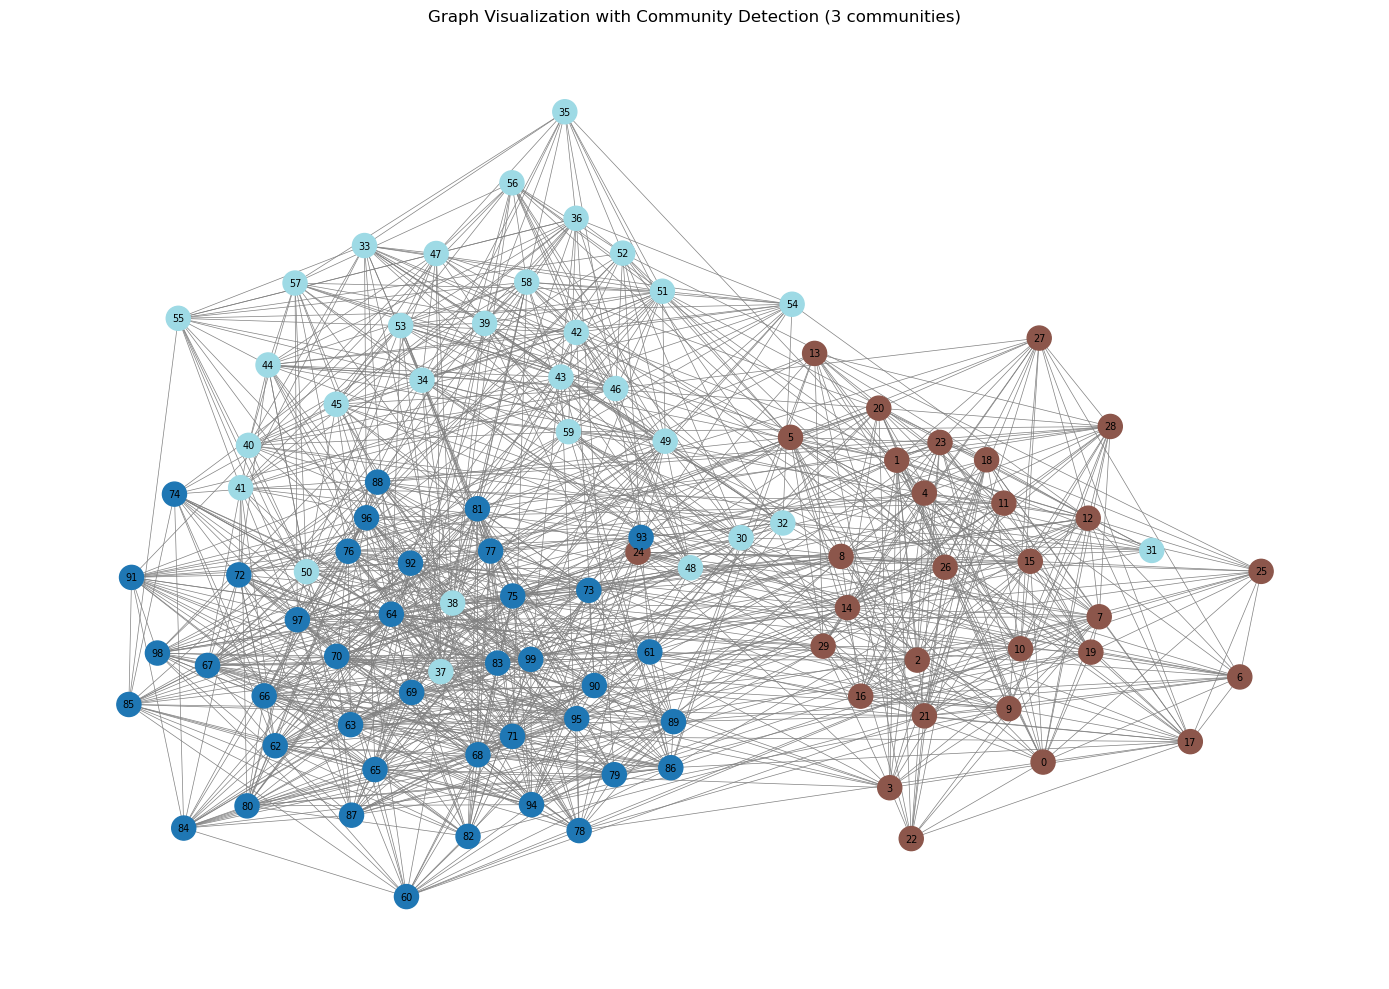

In [3]:
communities = list(community.greedy_modularity_communities(G))
color_map = [0] * len(G)
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw_networkx(G, pos, node_color=color_map, cmap='tab20', 
                 node_size=300, with_labels=True, font_size=7, edge_color='gray', width=0.5)
plt.title(f"Graph Visualization with Community Detection ({len(communities)} communities)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Prepare edge data with meeting weights (consistent with ex1 naming convention)
edges = np.array(list(G.edges()))
nodes_list = list(G.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes_list)}

# Convert edges to indices and extract meeting counts
edge_indices = np.array([[node_to_idx[u], node_to_idx[v]] for u, v in edges])
edge_meetings = np.array([G.edges[u, v]['meetings'] for u, v in edges])

n_nodes = len(nodes_list)

# Prepare faction and weighted degree data for visualization
factions = {}
for node in G.nodes():
    factions[node] = G.nodes[node]['faction']

weighted_degree = {node: sum(G[node][neighbor]['meetings'] for neighbor in G[node]) for node in G.nodes()}

print(f"Edge meetings - Min: {edge_meetings.min()}, Max: {edge_meetings.max()}, Mean: {edge_meetings.mean():.2f}")
print(f"Weighted degree - Min: {min(weighted_degree.values())}, Max: {max(weighted_degree.values())}, Mean: {np.mean(list(weighted_degree.values())):.2f}")
print(f"\nFaction distribution:")
for faction in ['Caesar', 'Pompey', 'Crassus']:
    count = sum(1 for f in factions.values() if f == faction)
    print(f"  {faction}: {count} politicians")

Edge meetings - Min: 1, Max: 45, Mean: 20.50
Weighted degree - Min: 225, Max: 727, Mean: 444.38

Faction distribution:
  Caesar: 30 politicians
  Pompey: 30 politicians
  Crassus: 40 politicians


In [ ]:
# Weighted Bayesian Latent Space Model with Faction-Informed Priors
# P(meetings_ij) = Poisson(lambda = exp(alpha - beta * ||z_i - z_j||))
# 
# Key insight: Crassus faction is disbanding. Some members have chosen sides (in CSV),
# others are undecided. We incorporate this as informative priors:
# - Caesar/Pompey members: positions pulled toward their faction centroid
# - Crassus members who chose a side: soft prior toward their new faction
# - Undecided Crassus members: uninformative prior (free to position anywhere)

latent_dim = 3  # Dimension of node embeddings

# Identify faction memberships and decisions
decided_crassus = set(assignees['node_id'].values)  # Crassus members who chose a side
crassus_to_new_faction = dict(zip(assignees['node_id'], assignees['new_faction']))

# Categorize nodes for hierarchical priors
caesar_nodes_set = set([n for n in G.nodes() if factions[n] == 'Caesar'])
pompey_nodes_set = set([n for n in G.nodes() if factions[n] == 'Pompey'])
crassus_decided_caesar = set([n for n in decided_crassus if crassus_to_new_faction[n] == 'Caesar'])
crassus_decided_pompey = set([n for n in decided_crassus if crassus_to_new_faction[n] == 'Pompey'])
crassus_undecided = set([n for n in G.nodes() if factions[n] == 'Crassus' and n not in decided_crassus])

print("Faction breakdown for priors:")
print(f"  Caesar faction: {len(caesar_nodes_set)} politicians")
print(f"  Pompey faction: {len(pompey_nodes_set)} politicians")
print(f"  Crassus (decided -> Caesar): {len(crassus_decided_caesar)} politicians")
print(f"  Crassus (decided -> Pompey): {len(crassus_decided_pompey)} politicians")
print(f"  Crassus (undecided): {len(crassus_undecided)} politicians")

# Create index arrays for each category
caesar_idx = np.array([node_to_idx[n] for n in caesar_nodes_set])
pompey_idx = np.array([node_to_idx[n] for n in pompey_nodes_set])
crassus_caesar_idx = np.array([node_to_idx[n] for n in crassus_decided_caesar])
crassus_pompey_idx = np.array([node_to_idx[n] for n in crassus_decided_pompey])
crassus_undecided_idx = np.array([node_to_idx[n] for n in crassus_undecided])

with pm.Model() as model:
    # Faction centroids as latent variables (hierarchical structure)
    # These represent the "center" of each faction in latent space
    caesar_centroid = pm.Normal('caesar_centroid', mu=0, sigma=1.0, shape=latent_dim)
    pompey_centroid = pm.Normal('pompey_centroid', mu=0, sigma=1.0, shape=latent_dim)
    
    # Within-faction spread (how tightly clustered each faction is)
    faction_sigma = pm.HalfNormal('faction_sigma', sigma=0.5)
    
    # Softer spread for Crassus members who chose a side (more uncertainty)
    transition_sigma = pm.HalfNormal('transition_sigma', sigma=1.0)
    
    z_components = []
    if len(caesar_idx) > 0:
        z_caesar = pm.Normal('z_caesar', mu=caesar_centroid, sigma=faction_sigma, 
                             shape=(len(caesar_idx), latent_dim))
        z_components.append((caesar_idx, z_caesar))

    if len(pompey_idx) > 0:
        z_pompey = pm.Normal('z_pompey', mu=pompey_centroid, sigma=faction_sigma,
                             shape=(len(pompey_idx), latent_dim))
        z_components.append((pompey_idx, z_pompey))

    if len(crassus_caesar_idx) > 0:
        z_crassus_caesar = pm.Normal('z_crassus_caesar', mu=caesar_centroid, sigma=transition_sigma,
                                     shape=(len(crassus_caesar_idx), latent_dim))
        z_components.append((crassus_caesar_idx, z_crassus_caesar))
    
    # Crassus members who chose Pompey: softer pull toward Pompey centroid
    if len(crassus_pompey_idx) > 0:
        z_crassus_pompey = pm.Normal('z_crassus_pompey', mu=pompey_centroid, sigma=transition_sigma,
                                     shape=(len(crassus_pompey_idx), latent_dim))
        z_components.append((crassus_pompey_idx, z_crassus_pompey))
    
    # Undecided Crassus members: uninformative prior (free positioning)
    if len(crassus_undecided_idx) > 0:
        z_undecided = pm.Normal('z_undecided', mu=0, sigma=1.5,
                                shape=(len(crassus_undecided_idx), latent_dim))
        z_components.append((crassus_undecided_idx, z_undecided))
    
    # Assemble full z matrix by preallocating and filling
    z_list = [None] * n_nodes
    for idx_array, z_subset in z_components:
        for i, node_idx in enumerate(idx_array):
            z_list[node_idx] = z_subset[i]
    
    # Stack into a single matrix using pt.as_tensor_variable
    import pytensor.tensor as pt
    z = pt.as_tensor_variable(pt.stacklists(z_list))
    
    # Global intercept (baseline meeting rate)
    alpha = pm.Normal('alpha', mu=np.log(edge_meetings.mean()), sigma=1.0)
    
    # Distance scale parameter (positive)
    beta = pm.HalfNormal('beta', sigma=1.0)
    
    # Compute Euclidean distances for all observed edges
    z_i = z[edge_indices[:, 0]]
    z_j = z[edge_indices[:, 1]]
    distances = pm.math.sqrt(pm.math.sum((z_i - z_j)**2, axis=1) + 1e-6)  # Small epsilon for stability
    
    # Log-link: lambda = exp(alpha - beta * distance)
    log_lambda = alpha - beta * distances
    
    # Likelihood: Poisson distribution for meeting counts
    meetings_obs = pm.Poisson('meetings_obs', mu=pm.math.exp(log_lambda), observed=edge_meetings)
    
    print("\nHierarchical model with faction-informed priors created.")
    print("Prior structure:")
    print("  - Caesar/Pompey: Normal(faction_centroid, faction_sigma)")
    print("  - Crassus (decided): Normal(chosen_centroid, transition_sigma) [softer]")
    print("  - Crassus (undecided): Normal(0, 1.5) [uninformative]")
    print("\nStarting inference...")
    
    trace = pm.sample(
        draws=7500,
        tune=3000,
        cores=6,
        chains=6,
        random_seed=42,
        progressbar=True,
        return_inferencedata=True,
        target_accept=0.95
    )

print("\nInference completed!")
print(f"Model trained on meeting counts (range: {edge_meetings.min()}-{edge_meetings.max()})")
print("\nConvergence Summary (key parameters):")
summary = az.summary(trace, var_names=['alpha', 'beta', 'faction_sigma', 'transition_sigma', 
                                        'caesar_centroid', 'pompey_centroid'])
print(summary)

Faction breakdown for priors:
  Caesar faction: 30 politicians
  Pompey faction: 30 politicians
  Crassus (decided -> Caesar): 10 politicians
  Crassus (decided -> Pompey): 10 politicians
  Crassus (undecided): 20 politicians

Hierarchical model with faction-informed priors created.
Prior structure:
  - Caesar/Pompey: Normal(faction_centroid, faction_sigma)
  - Crassus (decided): Normal(chosen_centroid, transition_sigma) [softer]
  - Crassus (undecided): Normal(0, 1.5) [uninformative]

Starting inference...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [caesar_centroid, pompey_centroid, faction_sigma, transition_sigma, z_caesar, z_pompey, z_crassus_caesar, z_crassus_pompey, z_undecided, alpha, beta]


Output()

Sampling 6 chains for 3_000 tune and 7_500 draw iterations (18_000 + 45_000 draws total) took 1492 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.



Inference completed!
Model trained on meeting counts (range: 1-45)

Convergence Summary (key parameters):
                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha               3.677  0.021   3.639    3.717      0.000    0.000   
beta                0.457  0.043   0.379    0.539      0.001    0.000   
faction_sigma       0.408  0.047   0.319    0.495      0.001    0.000   
transition_sigma    2.950  0.338   2.342    3.598      0.004    0.002   
caesar_centroid[0] -0.035  2.719  -4.540    4.488      0.061    0.018   
caesar_centroid[1]  0.051  2.743  -4.473    4.578      0.063    0.019   
caesar_centroid[2] -0.088  2.767  -4.656    4.454      0.068    0.019   
pompey_centroid[0] -0.005  2.729  -4.484    4.509      0.066    0.018   
pompey_centroid[1] -0.073  2.741  -4.519    4.507      0.067    0.019   
pompey_centroid[2]  0.046  2.731  -4.488    4.553      0.068    0.019   

                    ess_bulk  ess_tail  r_hat  
alpha                36057.0   31905.0   

In [22]:
# Extract posterior embeddings from the hierarchical model
# Reconstruct full z matrix from faction-specific components

# Get posterior means for each component
z_caesar_post = trace.posterior['z_caesar'].mean(dim=['chain', 'draw']).values if len(caesar_idx) > 0 else None
z_pompey_post = trace.posterior['z_pompey'].mean(dim=['chain', 'draw']).values if len(pompey_idx) > 0 else None
z_crassus_caesar_post = trace.posterior['z_crassus_caesar'].mean(dim=['chain', 'draw']).values if len(crassus_caesar_idx) > 0 else None
z_crassus_pompey_post = trace.posterior['z_crassus_pompey'].mean(dim=['chain', 'draw']).values if len(crassus_pompey_idx) > 0 else None
z_undecided_post = trace.posterior['z_undecided'].mean(dim=['chain', 'draw']).values if len(crassus_undecided_idx) > 0 else None

# Reconstruct full z_posterior matrix
z_posterior = np.zeros((n_nodes, latent_dim))

if z_caesar_post is not None:
    z_posterior[caesar_idx] = z_caesar_post
if z_pompey_post is not None:
    z_posterior[pompey_idx] = z_pompey_post
if z_crassus_caesar_post is not None:
    z_posterior[crassus_caesar_idx] = z_crassus_caesar_post
if z_crassus_pompey_post is not None:
    z_posterior[crassus_pompey_idx] = z_crassus_pompey_post
if z_undecided_post is not None:
    z_posterior[crassus_undecided_idx] = z_undecided_post

# Get learned faction centroids
caesar_centroid_post = trace.posterior['caesar_centroid'].mean(dim=['chain', 'draw']).values
pompey_centroid_post = trace.posterior['pompey_centroid'].mean(dim=['chain', 'draw']).values

print(f"Reconstructed embeddings shape: {z_posterior.shape}")
print(f"\nLearned faction centroids:")
print(f"  Caesar: {caesar_centroid_post}")
print(f"  Pompey: {pompey_centroid_post}")
print(f"  Distance between centroids: {np.linalg.norm(caesar_centroid_post - pompey_centroid_post):.3f}")

# Calculate pairwise distances in latent space for all edges
latent_distances = []
actual_meetings = []

for u, v in G.edges():
    u_idx = node_to_idx[u]
    v_idx = node_to_idx[v]
    
    # Euclidean distance in latent space
    dist = np.linalg.norm(z_posterior[u_idx] - z_posterior[v_idx])
    latent_distances.append(dist)
    actual_meetings.append(G.edges[u, v]['meetings'])

latent_distances = np.array(latent_distances)
actual_meetings = np.array(actual_meetings)

# Generate posterior predictive samples
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

# Extract posterior predictive samples
predicted_meetings_samples = az.extract(
    ppc,
    group="posterior_predictive",
    var_names=["meetings_obs"]
).values
# az.extract returns shape (n_edges, n_samples), transpose to (n_samples, n_edges)
predicted_meetings_samples = predicted_meetings_samples.T

n_samples, n_edges = predicted_meetings_samples.shape
print(f"Posterior predictive samples shape: {predicted_meetings_samples.shape}")

# Compute posterior predictive mean and credible intervals
predicted_mean = predicted_meetings_samples.mean(axis=0)
predicted_lower = np.percentile(predicted_meetings_samples, 2.5, axis=0)
predicted_upper = np.percentile(predicted_meetings_samples, 97.5, axis=0)

# Calculate goodness-of-fit metrics
# Correlation between latent distance and meeting count (should be negative: closer = more meetings)
pearson_corr, p_value = pearsonr(-latent_distances, actual_meetings)
spearman_corr, sp_pvalue = spearmanr(-latent_distances, actual_meetings)

# Posterior predictive coverage (% of observations within 95% CI)
coverage = np.mean((actual_meetings >= predicted_lower) & (actual_meetings <= predicted_upper))

# R-squared (coefficient of determination)
ss_res = np.sum((actual_meetings - predicted_mean) ** 2)
ss_tot = np.sum((actual_meetings - actual_meetings.mean()) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Adjusted R-squared
n_data = len(actual_meetings)
n_params = n_nodes * latent_dim + 2 + 2 * latent_dim  # z's + alpha, beta + centroids
r_squared_adj = 1 - (1 - r_squared) * (n_data - 1) / (n_data - n_params - 1)

# Mean Absolute Error
mae = np.mean(np.abs(actual_meetings - predicted_mean))

# Root Mean Squared Error
rmse = np.sqrt(np.mean((actual_meetings - predicted_mean) ** 2))

print("Correlation (latent distance vs meetings):")
print(f"  Pearson r = {pearson_corr:.4f} (p = {p_value:.2e})")
print(f"  Spearman ρ = {spearman_corr:.4f} (p = {sp_pvalue:.2e})")
print("Predictive Performance:")
print(f"  R² = {r_squared:.4f}")
print(f"  Adjusted R² = {r_squared_adj:.4f}")
print(f"  MAE = {mae:.2f} meetings")
print(f"  RMSE = {rmse:.2f} meetings")
print("Posterior Predictive Check:")
print(f"  95% CI Coverage = {coverage:.1%}")

Sampling: [meetings_obs]


Output()

Reconstructed embeddings shape: (100, 3)

Learned faction centroids:
  Caesar: [-0.03540325  0.05105792 -0.08801956]
  Pompey: [-0.00541132 -0.07349932  0.04573366]
  Distance between centroids: 0.185


Posterior predictive samples shape: (45000, 1084)
Correlation (latent distance vs meetings):
  Pearson r = 0.8546 (p = 3.70e-310)
  Spearman ρ = 0.7806 (p = 4.97e-223)
Predictive Performance:
  R² = 0.9054
  Adjusted R² = 0.8678
  MAE = 2.63 meetings
  RMSE = 3.46 meetings
Posterior Predictive Check:
  95% CI Coverage = 99.7%


Learned embeddings shape: (100, 3)
Embedding statistics:
  Mean: -0.0097
  Std: 0.0438

Ranges for Dimensions in R^3 latent space:
  Dimension 1 range: [-0.04, 0.01]
  Dimension 2 range: [-0.09, 0.06]
  Dimension 3 range: [-0.10, 0.06]


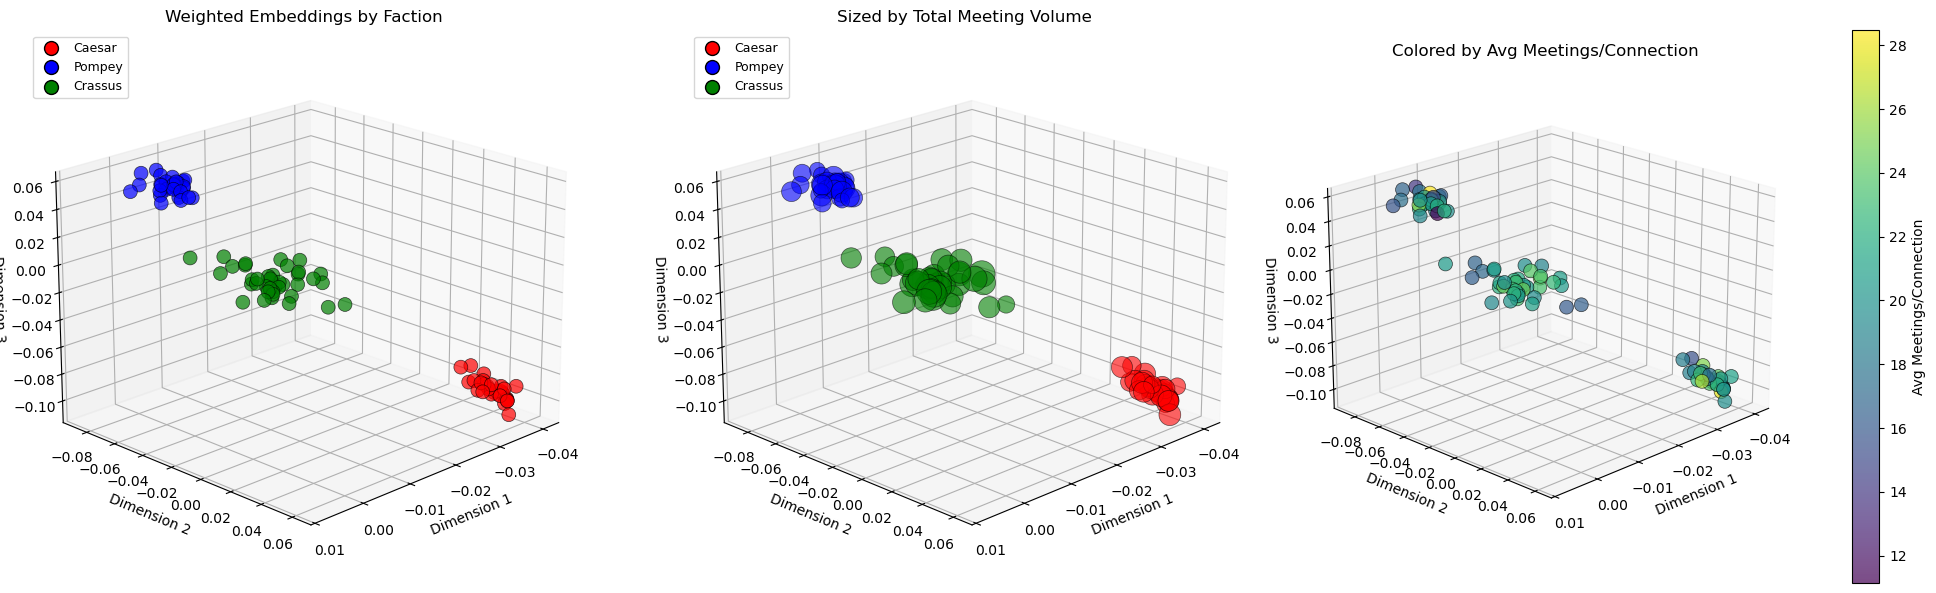

In [ ]:
# Extract learned embeddings (posterior mean)
z_posterior_full = np.zeros((n_nodes, latent_dim))

if z_caesar_post is not None:
    z_posterior_full[caesar_idx] = z_caesar_post
if z_pompey_post is not None:
    z_posterior_full[pompey_idx] = z_pompey_post
if z_crassus_caesar_post is not None:
    z_posterior_full[crassus_caesar_idx] = z_crassus_caesar_post
if z_crassus_pompey_post is not None:
    z_posterior_full[crassus_pompey_idx] = z_crassus_pompey_post
if z_undecided_post is not None:
    z_posterior_full[crassus_undecided_idx] = z_undecided_post

print(f"Learned embeddings shape: {z_posterior_full.shape}")
print(f"Embedding statistics:\n  Mean: {z_posterior_full.mean():.4f}\n  Std: {z_posterior_full.std():.4f}")

z_3d = z_posterior_full

print(f"\nRanges for Dimensions in R^{latent_dim} latent space:")
print(f"  Dimension 1 range: [{z_3d[:, 0].min():.2f}, {z_3d[:, 0].max():.2f}]")
print(f"  Dimension 2 range: [{z_3d[:, 1].min():.2f}, {z_3d[:, 1].max():.2f}]")
print(f"  Dimension 3 range: [{z_3d[:, 2].min():.2f}, {z_3d[:, 2].max():.2f}]")

# Calculate average meeting volume for each node
node_avg_meetings = {}
for node in G.nodes():
    total_meetings = sum(G[node][neighbor]['meetings'] for neighbor in G[node])
    node_avg_meetings[node] = total_meetings / G.degree(node)

# Create discrete colormap for factions
faction_cmap = ListedColormap(['red', 'blue', 'green'])
faction_labels = ['Caesar', 'Pompey', 'Crassus']

fig = plt.figure(figsize=(20, 6))

# Plot 1: Embeddings colored by faction
ax = fig.add_subplot(131, projection='3d')
node_factions = [factions[nodes_list[i]] for i in range(len(nodes_list))]
faction_colors_map = {'Caesar': 0, 'Pompey': 1, 'Crassus': 2}
faction_colors = [faction_colors_map[f] for f in node_factions]

scatter1 = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], c=faction_colors, s=100, 
                      cmap=faction_cmap, alpha=0.7, edgecolors='black', linewidth=0.5, vmin=0, vmax=2)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Weighted Embeddings by Faction')
# Create custom legend instead of colorbar
ax.legend([plt.scatter([], [], c='red', s=100, edgecolors='black'),
           plt.scatter([], [], c='blue', s=100, edgecolors='black'),
           plt.scatter([], [], c='green', s=100, edgecolors='black')],
          faction_labels, loc='upper left', fontsize=9)

# Plot 2: Embeddings sized by total meeting volume
ax = fig.add_subplot(132, projection='3d')
total_meetings_per_node = [weighted_degree[nodes_list[i]] for i in range(len(nodes_list))]
scatter2 = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], c=faction_colors, 
                      s=np.array(total_meetings_per_node) / 2, 
                      cmap=faction_cmap, alpha=0.6, edgecolors='black', linewidth=0.5, vmin=0, vmax=2)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Sized by Total Meeting Volume')
ax.legend([plt.scatter([], [], c='red', s=100, edgecolors='black'),
           plt.scatter([], [], c='blue', s=100, edgecolors='black'),
           plt.scatter([], [], c='green', s=100, edgecolors='black')],
          faction_labels, loc='upper left', fontsize=9)

# Plot 3: Embeddings colored by average meetings per connection
ax = fig.add_subplot(133, projection='3d')
avg_meetings_per_node = [node_avg_meetings[nodes_list[i]] for i in range(len(nodes_list))]
scatter3 = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], c=avg_meetings_per_node, s=100, 
                      cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Colored by Avg Meetings/Connection')
cbar3 = plt.colorbar(scatter3, ax=ax, label='Avg Meetings/Connection', pad=0.1)

# Make plots interactive - rotate for better viewing
for ax in [fig.axes[0], fig.axes[1], fig.axes[2]]:
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# Question 1: Which faction should the undecided Crassus politicians join?

In [28]:
# Question 1: Which faction (Caesar or Pompey) should undecided Crassus politicians join?
# Ignore Crassus as option since the faction is dismantling

# Identify undecided Crassus politicians
decided_nodes = set(assignees['node_id'].values)
undecided_crassus = [n for n in G.nodes() if factions[n] == 'Crassus' and n not in decided_nodes]

# Compute faction centroids in latent space (only Caesar and Pompey)
caesar_nodes = [n for n in G.nodes() if factions[n] == 'Caesar']
pompey_nodes = [n for n in G.nodes() if factions[n] == 'Pompey']

caesar_indices = [node_to_idx[n] for n in caesar_nodes]
pompey_indices = [node_to_idx[n] for n in pompey_nodes]

caesar_centroid_learned = z_posterior[caesar_indices].mean(axis=0)
pompey_centroid_learned = z_posterior[pompey_indices].mean(axis=0)

# Analyze each undecided politician
undecided_analysis = []

for node in undecided_crassus:
    node_idx = node_to_idx[node]
    embedding = z_3d[node_idx]
    
    # Distance to each faction centroid
    dist_to_caesar = np.linalg.norm(embedding - caesar_centroid_learned)
    dist_to_pompey = np.linalg.norm(embedding - pompey_centroid_learned)
    
    # Count meetings to Caesar and Pompey only (not Crassus)
    caesar_meetings = 0
    pompey_meetings = 0
    
    for neighbor in G[node]:
        if factions[neighbor] == 'Caesar':
            caesar_meetings += G[node][neighbor]['meetings']
        elif factions[neighbor] == 'Pompey':
            pompey_meetings += G[node][neighbor]['meetings']
    
    # Normalize distance: closer = higher score (invert)
    max_dist = max(dist_to_caesar, dist_to_pompey)
    if max_dist > 0:
        distance_score_caesar = 1 - (dist_to_caesar / max_dist)
        distance_score_pompey = 1 - (dist_to_pompey / max_dist)
    else:
        distance_score_caesar = 0.5
        distance_score_pompey = 0.5
    
    # Normalize meetings: more = higher score
    total_meetings = caesar_meetings + pompey_meetings
    if total_meetings > 0:
        meetings_score_caesar = caesar_meetings / total_meetings
        meetings_score_pompey = pompey_meetings / total_meetings
    else:
        meetings_score_caesar = 0.5
        meetings_score_pompey = 0.5
    
    # Combined score: 50% distance + 50% meetings
    final_score_caesar = 0.5 * distance_score_caesar + 0.5 * meetings_score_caesar
    final_score_pompey = 0.5 * distance_score_pompey + 0.5 * meetings_score_pompey
    
    # Determine recommendation
    recommendation = 'Caesar' if final_score_caesar > final_score_pompey else 'Pompey'
    
    undecided_analysis.append({
        'node': node,
        'dist_to_caesar': dist_to_caesar,
        'dist_to_pompey': dist_to_pompey,
        'caesar_meetings': caesar_meetings,
        'pompey_meetings': pompey_meetings,
        'distance_score_caesar': distance_score_caesar,
        'distance_score_pompey': distance_score_pompey,
        'meetings_score_caesar': meetings_score_caesar,
        'meetings_score_pompey': meetings_score_pompey,
        'final_score_caesar': final_score_caesar,
        'final_score_pompey': final_score_pompey,
        'recommendation': recommendation
    })

# Create DataFrame and analyze
undecided_df_q1 = pd.DataFrame(undecided_analysis)
print("\nScoring: 50% Latent Distance + 50% Meeting Volume")

recommendation_counts = undecided_df_q1['recommendation'].value_counts()
print("Recommendation Summary:")
for faction, count in recommendation_counts.items():
    percentage = (count / len(undecided_df_q1)) * 100
    print(f"  {faction}: {count} politicians ({percentage:.1f}%)")


for idx, row in undecided_df_q1.iterrows():
    node = row['node']
    recommendation = row['recommendation']
    print(f"Node {node:2d} → {recommendation}")

# Sort by confidence (how much stronger one option is over the other)
undecided_df_q1['confidence'] = abs(undecided_df_q1['final_score_caesar'] - undecided_df_q1['final_score_pompey'])
undecided_df_q1_sorted = undecided_df_q1.sort_values('confidence', ascending=False)


Scoring: 50% Latent Distance + 50% Meeting Volume
Recommendation Summary:
  Pompey: 11 politicians (55.0%)
  Caesar: 9 politicians (45.0%)
Node 61 → Caesar
Node 62 → Caesar
Node 63 → Pompey
Node 64 → Pompey
Node 66 → Pompey
Node 71 → Caesar
Node 73 → Caesar
Node 75 → Pompey
Node 77 → Caesar
Node 78 → Pompey
Node 79 → Pompey
Node 80 → Pompey
Node 81 → Pompey
Node 82 → Caesar
Node 85 → Caesar
Node 88 → Pompey
Node 89 → Caesar
Node 90 → Pompey
Node 93 → Pompey
Node 98 → Caesar


## Exercise 2, Question 2: Most Undecided Politicians

**Who are the most undecided politicians when it comes to choosing between Caesar and Pompey?**

To identify undecided politicians from Crassus faction, we analyze:
1. **Distance from faction centroids in latent space**: Undecided politicians should be equidistant from both Caesar and Pompey centroids
2. **Balance of connections**: Equal number of connections/meetings to both factions
3. **Embedding position**: Located near the boundary between the two factions

We use the **meetings** edge attribute to weight the importance of connections - politicians with more meetings to both factions are more engaged and their indecision is more significant.

In [29]:
# Compute faction centroids in latent space
caesar_nodes = [n for n in G.nodes() if factions[n] == 'Caesar']
pompey_nodes = [n for n in G.nodes() if factions[n] == 'Pompey']
crassus_nodes = [n for n in G.nodes() if factions[n] == 'Crassus']

caesar_indices = [node_to_idx[n] for n in caesar_nodes]
pompey_indices = [node_to_idx[n] for n in pompey_nodes]
crassus_indices = [node_to_idx[n] for n in crassus_nodes]

caesar_centroid = z_posterior[caesar_indices].mean(axis=0)
pompey_centroid = z_posterior[pompey_indices].mean(axis=0)
crassus_centroid = z_posterior[crassus_indices].mean(axis=0)

print(f"Faction centroids in latent space:")
print(f"  Caesar centroid: [{caesar_centroid[0]:.3f}, {caesar_centroid[1]:.3f}]")
print(f"  Pompey centroid: [{pompey_centroid[0]:.3f}, {pompey_centroid[1]:.3f}]")
print(f"  Crassus centroid: [{crassus_centroid[0]:.3f}, {crassus_centroid[1]:.3f}]")

# For each Crassus politician, calculate metrics of indecision
undecided_candidates = []

for node in crassus_nodes:
    node_idx = node_to_idx[node]
    embedding = z_posterior[node_idx]
    
    # Distance to each faction centroid
    dist_to_caesar = np.linalg.norm(embedding - caesar_centroid)
    dist_to_pompey = np.linalg.norm(embedding - pompey_centroid)
    
    # Balance score: 0 = perfectly balanced, 1 = strongly biased
    balance_score = abs(dist_to_caesar - dist_to_pompey) / (dist_to_caesar + dist_to_pompey)
    
    # Count connections and meetings to each faction
    caesar_connections = 0
    caesar_meetings = 0
    pompey_connections = 0
    pompey_meetings = 0
    
    for neighbor in G[node]:
        if factions[neighbor] == 'Caesar':
            caesar_connections += 1
            caesar_meetings += G[node][neighbor]['meetings']
        elif factions[neighbor] == 'Pompey':
            pompey_connections += 1
            pompey_meetings += G[node][neighbor]['meetings']
    
    total_connections = caesar_connections + pompey_connections
    total_meetings = caesar_meetings + pompey_meetings
    
    # Connection balance (0 = perfectly balanced, 1 = all one side)
    if total_connections > 0:
        connection_balance = abs(caesar_connections - pompey_connections) / total_connections
    else:
        connection_balance = 1.0
    
    # Meeting balance (0 = perfectly balanced, 1 = all one side)
    if total_meetings > 0:
        meeting_balance = abs(caesar_meetings - pompey_meetings) / total_meetings
    else:
        meeting_balance = 1.0
    
    # Composite undecided score (lower = more undecided)
    # Weight: 40% distance balance + 30% connection balance + 30% meeting balance
    undecided_score = 0.4 * balance_score + 0.3 * connection_balance + 0.3 * meeting_balance
    
    undecided_candidates.append({
        'node': node,
        'dist_to_caesar': dist_to_caesar,
        'dist_to_pompey': dist_to_pompey,
        'distance_balance': balance_score,
        'caesar_connections': caesar_connections,
        'pompey_connections': pompey_connections,
        'connection_balance': connection_balance,
        'caesar_meetings': caesar_meetings,
        'pompey_meetings': pompey_meetings,
        'meeting_balance': meeting_balance,
        'total_meetings': total_meetings,
        'undecided_score': undecided_score
    })

# Create DataFrame and sort by undecided score (lower = more undecided)
undecided_df = pd.DataFrame(undecided_candidates).sort_values('undecided_score')
print("\nComposite Score = 40% Distance Balance + 30% Connection Balance + 30% Meeting Balance")
print("(Lower score = more undecided/balanced between Caesar and Pompey)\n")

print("Most undecided politicians")
for idx, row in undecided_df.head(10).iterrows():
    print(f"\nNode {row['node']} - Undecided Score: {row['undecided_score']:.3f}")
    print("  Latent Space Analysis:")
    print(f"    - Distance to Caesar: {row['dist_to_caesar']:.3f}")
    print(f"    - Distance to Pompey: {row['dist_to_pompey']:.3f}")
    print(f"    - Distance Balance: {row['distance_balance']:.3f} (0=balanced, 1=biased)")
    print("  Network Connections:")
    print(f"    - Caesar: {row['caesar_connections']} connections, {row['caesar_meetings']} meetings")
    print(f"    - Pompey: {row['pompey_connections']} connections, {row['pompey_meetings']} meetings")
    print(f"    - Connection Balance: {row['connection_balance']:.3f}")
    print(f"    - Meeting Balance: {row['meeting_balance']:.3f}")

Faction centroids in latent space:
  Caesar centroid: [-0.036, 0.051]
  Pompey centroid: [-0.006, -0.075]
  Crassus centroid: [-0.004, 0.003]

Composite Score = 40% Distance Balance + 30% Connection Balance + 30% Meeting Balance
(Lower score = more undecided/balanced between Caesar and Pompey)

Most undecided politicians

Node 77.0 - Undecided Score: 0.088
  Latent Space Analysis:
    - Distance to Caesar: 0.098
    - Distance to Pompey: 0.100
    - Distance Balance: 0.006 (0=balanced, 1=biased)
  Network Connections:
    - Caesar: 2.0 connections, 9.0 meetings
    - Pompey: 2.0 connections, 5.0 meetings
    - Connection Balance: 0.000
    - Meeting Balance: 0.286

Node 69.0 - Undecided Score: 0.095
  Latent Space Analysis:
    - Distance to Caesar: 0.111
    - Distance to Pompey: 0.092
    - Distance Balance: 0.090 (0=balanced, 1=biased)
  Network Connections:
    - Caesar: 3.0 connections, 10.0 meetings
    - Pompey: 4.0 connections, 9.0 meetings
    - Connection Balance: 0.143
    -

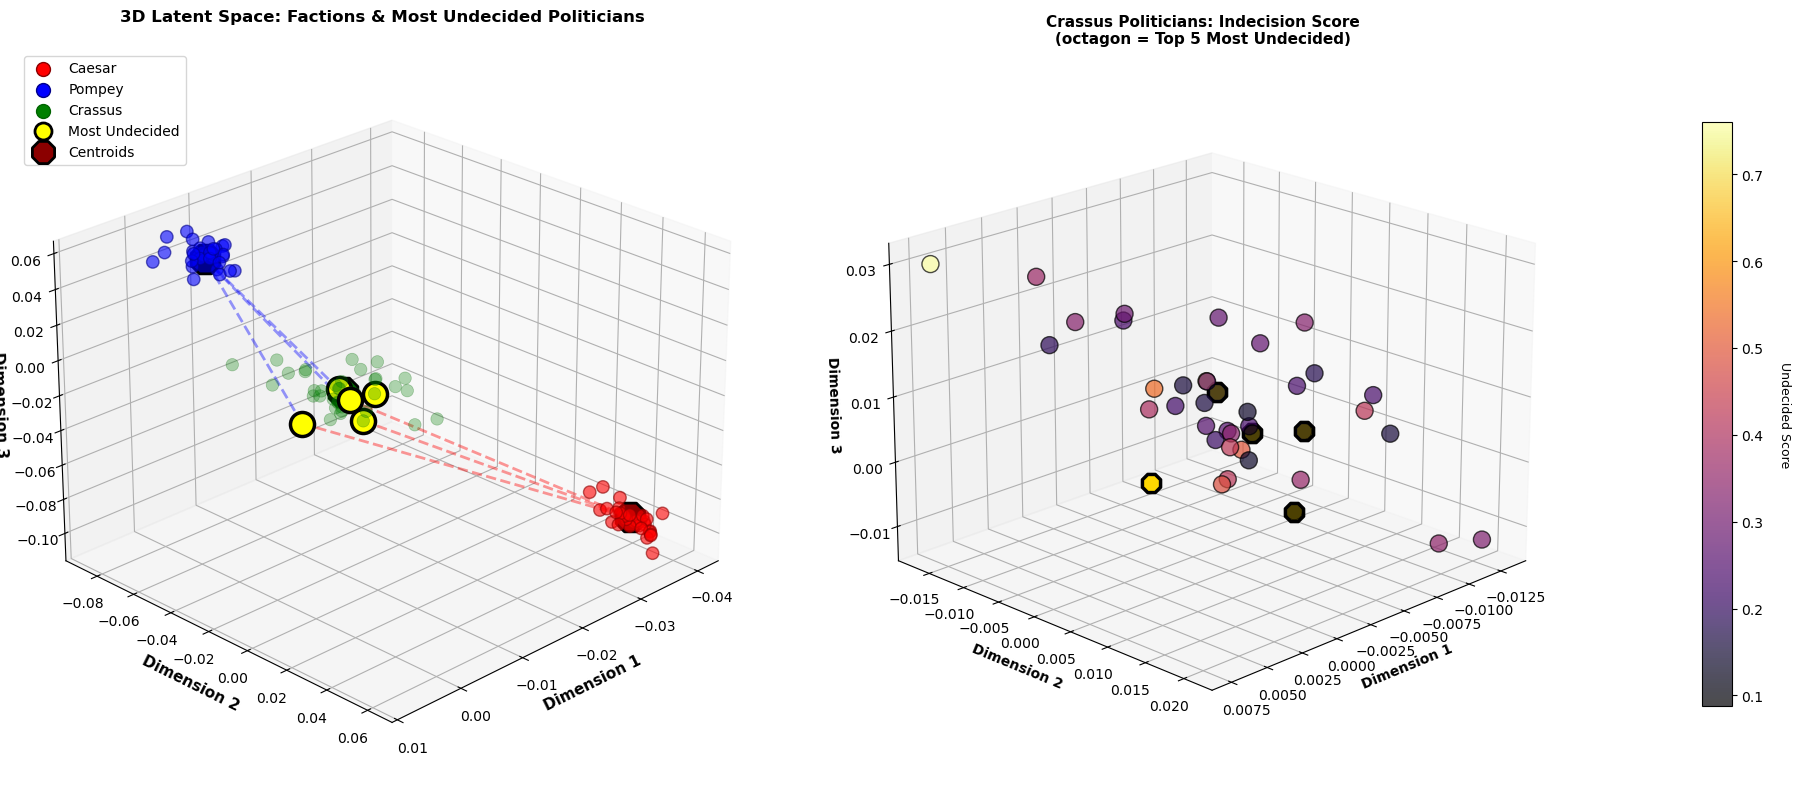

In [44]:
# Visualize latent space (3D) with faction centroids and undecided politicians
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 8))

faction_cmap = ListedColormap(['red', 'blue', 'green'])
faction_labels = ['Caesar', 'Pompey', 'Crassus']

# Plot 1: All politicians colored by faction with centroids (3D)
ax = fig.add_subplot(121, projection='3d')

crassus_mask = [factions[nodes_list[i]] == 'Crassus' for i in range(len(nodes_list))]
caesar_mask = [factions[nodes_list[i]] == 'Caesar' for i in range(len(nodes_list))]
pompey_mask = [factions[nodes_list[i]] == 'Pompey' for i in range(len(nodes_list))]

crassus_z = z_3d[crassus_mask]
caesar_z = z_3d[caesar_mask]
pompey_z = z_3d[pompey_mask]

# Plot factions with discrete colors
ax.scatter(caesar_z[:, 0], caesar_z[:, 1], caesar_z[:, 2], c='red', s=80, alpha=0.6, edgecolors='darkred', linewidth=1)
ax.scatter(pompey_z[:, 0], pompey_z[:, 1], pompey_z[:, 2], c='blue', s=80, alpha=0.6, edgecolors='darkblue', linewidth=1)
ax.scatter(crassus_z[:, 0], crassus_z[:, 1], crassus_z[:, 2], c='green', s=80, alpha=0.3, edgecolors='darkgreen', linewidth=0.5)

# Plot faction centroids as large markers
ax.scatter(*caesar_centroid_post, s=500, marker='8', c='darkred', edgecolors='black', linewidth=2, zorder=10)
ax.scatter(*pompey_centroid_post, s=500, marker='8', c='darkblue', edgecolors='black', linewidth=2, zorder=10)
ax.scatter(*crassus_centroid, s=500, marker='8', c='darkgreen', edgecolors='black', linewidth=2, zorder=10)

# Highlight top 5 most undecided politicians
top_undecided = undecided_df.head(5)
for idx, row in top_undecided.iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    ax.scatter(z_3d[node_idx, 0], z_3d[node_idx, 1], z_3d[node_idx, 2], s=300, marker='o', 
              c='yellow', edgecolors='black', linewidth=2.5, zorder=8)

# Draw lines from top 3 undecided to both centroids
for idx, row in top_undecided.head(3).iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    node_pos = z_3d[node_idx]
    
    ax.plot([node_pos[0], caesar_centroid_post[0]], [node_pos[1], caesar_centroid_post[1]], 
            [node_pos[2], caesar_centroid_post[2]], 'r--', alpha=0.4, linewidth=2)
    ax.plot([node_pos[0], pompey_centroid_post[0]], [node_pos[1], pompey_centroid_post[1]], 
            [node_pos[2], pompey_centroid_post[2]], 'b--', alpha=0.4, linewidth=2)

ax.set_xlabel('Dimension 1', fontsize=11, fontweight='bold')
ax.set_ylabel('Dimension 2', fontsize=11, fontweight='bold')
ax.set_zlabel('Dimension 3', fontsize=11, fontweight='bold')
ax.set_title('3D Latent Space: Factions & Most Undecided Politicians', fontsize=12, fontweight='bold', pad=20)


ax.legend([plt.scatter([], [], c='red', s=100, edgecolors='darkred', linewidth=1),
           plt.scatter([], [], c='blue', s=100, edgecolors='darkblue', linewidth=1),
           plt.scatter([], [], c='green', s=100, edgecolors='darkgreen', linewidth=1),
           plt.scatter([], [], c='yellow', s=150, marker='o', edgecolors='black', linewidth=2),
           plt.scatter([], [], c='darkred', s=300, marker='8', edgecolors='black', linewidth=2)],
          ['Caesar', 'Pompey', 'Crassus', 'Most Undecided', 'Centroids'],
          loc='upper left', fontsize=10)

ax.view_init(elev=25, azim=45)
ax.grid(True, alpha=0.3)

# Plot 2: All Crassus colored by undecided score with top 5 highlighted
ax2 = fig.add_subplot(122, projection='3d')
undecided_scores = undecided_df.set_index('node').loc[crassus_nodes]['undecided_score'].values

scatter2 = ax2.scatter(crassus_embeddings[:, 0], crassus_embeddings[:, 1], crassus_embeddings[:, 2],
                       c=undecided_scores, s=150, cmap='inferno', 
                       alpha=0.7, edgecolors='black', linewidth=1.0, 
                       vmin=undecided_scores.min(), vmax=undecided_scores.max())
cbar2 = plt.colorbar(scatter2, ax=ax2, pad=0.15, shrink=0.8)
cbar2.set_label('Undecided Score\n', rotation=270, labelpad=20, fontsize=9)

# Highlight top 5 most undecided with larger markers and annotations
for idx, row in top_undecided.iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    
    # Larger marker for top undecided
    ax2.scatter(z_3d[node_idx, 0], z_3d[node_idx, 1], z_3d[node_idx, 2], 
               s=200, marker='8', c='gold', edgecolors='black', linewidth=2.5, zorder=10)
    
    # Annotation with node ID
    ax2.text(z_3d[node_idx, 0], z_3d[node_idx, 1], z_3d[node_idx, 2] + 0.25, 
            f"Node {node}", fontsize=10, color='black', weight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8, edgecolor='black', linewidth=1.5))

ax2.set_xlabel('Dimension 1', fontsize=10, fontweight='bold')
ax2.set_ylabel('Dimension 2', fontsize=10, fontweight='bold')
ax2.set_zlabel('Dimension 3', fontsize=10, fontweight='bold')
ax2.set_title('Crassus Politicians: Indecision Score\n(octagon = Top 5 Most Undecided)', 
             fontsize=11, fontweight='bold', pad=15)
ax2.view_init(elev=20, azim=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
